In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
import seaborn as sns
import statsmodels.formula.api as smf
from adjustText import adjust_text

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
DATA_PATH_EAS2K = '/n/groups/price/martin/LDSPEC_data/UKBimp_EAS2K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_res.rv1'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables.rv1'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.rv1.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
TRAIT_LIST_INDPT10 = list(DF_TRAIT.index[~DF_TRAIT['Trait_Identifier_eas'].isna()])
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))
print("n_trait_indpt10=%d" % len(TRAIT_LIST_INDPT10))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.txt', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {
    'common' : '#78ADD2', 
    'lf' : '#FFB26E',
    ('p0_p100', 'common') : 'C0',
    ('p0_p100', 'lf') : 'C1',
    ('n100_p0', 'common') : 'C2',
    ('n100_p0', 'lf') : 'C3',
}

MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_trait_indpt10=10
n_annot=45
n_pannot=34


### Load results and meta-analysis

In [3]:
# Load results 
DIC_RES_PATH = {
    'md_bsl' : DATA_PATH + '/ldspec_res_092223.bsl/@t',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/ldspec_res_092223.prox_gene_fct_all_ld/@t',
    'prox_gene_fct_all_ld_EAS2K' : DATA_PATH_EAS2K + '/ldspec_res_040925.prox_gene_fct_all_ld_common_EAS2K/@t',
}
md0 = 'md_bsl'
dic_trait_eas = {x:y for x,y in zip(DF_TRAIT['Trait_Identifier'], DF_TRAIT['Trait_Identifier_eas'])}


# Load .pickle files: dic_res[md][trait] = .pickle
dic_res = {}
missing_list = []
for md in DIC_RES_PATH:
    dic_res[md] = {}   
    if md == 'prox_gene_fct_all_ld_EAS2K':
        temp_list = TRAIT_LIST_INDPT10
    else:
        temp_list = TRAIT_LIST_INDPT
    for i,trait in enumerate(temp_list):
        # for EAS, use `Trait_Identifier` to be consistent
        trait_val = dic_trait_eas[trait] if md=='prox_gene_fct_all_ld_EAS2K' else trait
        if os.path.exists(DIC_RES_PATH[md].replace("@t", trait_val) + ".pickle"):
            with open(DIC_RES_PATH[md].replace("@t", trait_val) + ".pickle", "br") as f:
                dic_res[md][trait] = pickle.load(f)
            # Check avgr
            with open(DIC_RES_PATH[md].replace("@t", trait_val) + ".sbatch.log", "r") as f:
                for line in f:
                    if 'Detected AVGR for' in line:
                        line = line.strip()
                        n1,n2 = line.split(' ')[3].split('/')
                        if n1!=n2: 
                            print("Missing AVGR: %-20s %-35s %s %s" % (md, trait, i+1, line))
        else:
            print("Missing %-10s %-30s %s" % (md, trait, i+1))
            if trait not in missing_list: 
                missing_list.append(trait)
                
# Check AN_list and pAN_list are same across traits for a given method
print('Check matching of AN_list and pAN_list')
for md in DIC_RES_PATH:
    print('    %s' % md)
    AN_list_md = list(dic_res[md][TRAIT_LIST_INDPT10[0]]['summary']['tau'].index)
    pAN_list_md = list(dic_res[md][TRAIT_LIST_INDPT10[0]]['summary']['omega'].index)
    for trait in dic_res[md]:
        if set(dic_res[md][trait]['summary']['tau'].index) != set(AN_list_md):
            print('    AN_list not match: %s' % trait)
        if set(dic_res[md][trait]['summary']['omega'].index) != set(pAN_list_md):
            print('    pAN_list not match: %s' % trait)

# Collect info
print('n_missing_trait=%d' % len(missing_list))
AN_list = list(dic_res[md0][TRAIT_LIST_INDPT10[0]]['summary']['tau'].index)
print('AN_list=%d' % len(AN_list))
pAN_list = []
for md in DIC_RES_PATH:
    pAN_list += [x for x in dic_res[md][TRAIT_LIST_INDPT10[0]]['summary']['omega'].index if x not in pAN_list]
print('pAN_list=%d' % len(pAN_list))

# Trait with h2_z>5
TRAIT_LIST_META = []
for trait in TRAIT_LIST_INDPT:
    h2 = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2']
    h2_se = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2_se']
    h2_z = h2 / h2_se
    if h2_z > 5:
        TRAIT_LIST_META.append(trait)
    else:
        print('    %-20s    h2=%0.3f    h2_z=%0.2f' % (trait, h2, h2_z))
print('%d/%d traits with h2z>5' % (len(TRAIT_LIST_META), len(TRAIT_LIST_INDPT)))

Check matching of AN_list and pAN_list
    md_bsl
    md_prox_gene_fct_all_ld
    prox_gene_fct_all_ld_EAS2K
n_missing_trait=0
AN_list=165
pAN_list=136
29/29 traits with h2z>5


In [4]:
# Meta-analysis using TRAIT_LIST_META
dic_term_list = {
    'tau': ['tau', 'h2', 'scv', 'h2_enrich', 'scv_enrich', 'h2_shrink'], 
    'omega': ['omega', 'cov', 'cor', 'ecov', 'ecor'],
}

dic_res_meta = {}
for md in DIC_RES_PATH:
    if md == 'prox_gene_fct_all_ld_EAS2K':
        continue
    dic_res_meta[md] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_META]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_META]
    for res in ['tau', 'omega']:
        dic_res_meta[md][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta[md][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta[md][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_

/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:385: RuntimeWarning: overflow encountered in multiply
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:365: RuntimeWarning: divide by zero encountered in true_divide
  vwts = 1.0 / variances
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:369: RuntimeWarning: invalid value encountered in float_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))


In [5]:
# Meta-analysis using TRAIT_LIST_INDPT10 (all in TRAIT_LIST_META)
for md in ['prox_gene_fct_all_ld_EAS2K', 'md_prox_gene_fct_all_ld']:
    # .indpt10 version of md_prox_gene_fct_all_ld
    md_key = md+'.indpt10' if md == 'md_prox_gene_fct_all_ld' else md
    dic_res_meta[md_key] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_INDPT10]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_INDPT10]
    for res in ['tau', 'omega']:
        dic_res_meta[md_key][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT10[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta[md_key][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta[md_key][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_

In [6]:
# Write tables
md = 'prox_gene_fct_all_ld_EAS2K'
for res in ['tau', 'omega']:
    # Individual trait results
    temp_list = []
    for trait in TRAIT_LIST_INDPT10:
        temp_df = dic_res[md][trait]['summary'][res].copy()
        temp_df['trait'] = trait
        temp_df = temp_df[['trait'] + [x for x in temp_df if x!='trait']]
        temp_list.append(temp_df)
    temp_df = pd.concat(temp_list, axis=0)
    temp_df.to_csv(TAB_PATH+'/ldspec.%s.%s.tsv' % (md,res), sep='\t', index=False)
    
    # Meta-analyzed results
    dic_res_meta[md][res].to_csv(TAB_PATH+'/ldspec_meta.%s.%s.tsv' % (md,res), sep='\t')

In [7]:
# quick comparison
temp_df1 = dic_res_meta['md_prox_gene_fct_all_ld.indpt10']['tau']
temp_df2 = dic_res_meta['prox_gene_fct_all_ld_EAS2K']['tau']
shared_row = list(set(temp_df1.index) & set(temp_df2.index))

for term in ['tau', 'h2', 'h2_enrich']:
    print(term)
    v1 = temp_df1.loc[shared_row, term].values
    v2 = temp_df2.loc[shared_row, term].values
    ind_select = ~np.isnan(v1) & ~np.isnan(v2)
    print(np.corrcoef(v1[ind_select], v2[ind_select])[0,1])

tau
0.29498665662513934
h2
0.9794469487403628
h2_enrich
0.4989337609963805


### Comparison of results 

In [8]:
# bar_plot 
md = 'prox_gene_fct_all_ld_EAS2K'
mbin = 'common'
plot_list_main = [
    'proxy_0_100', 'proxy_100_1000', 'proxy_1000_10000', 
    'exon', 'exonic_gene', 'cS2G_promoter', 'protein_domain', 'gene',
]
plot_list_100 = sorted([x for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-100']])
plot_list_1k = sorted([x for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-1k']])
plot_list = plot_list_main + plot_list_100 + plot_list_1k

df_plot = pd.DataFrame(
    index = plot_list, dtype = float, 
    columns = [
        '%s.%s.%s%s' % (x, y, z, q)
        for x in ['cor', 'ecor'] 
        for y in ['n100_p0', 'p0_p100'] 
        for z in ['common'] 
        for q in ['', '.se', '.p', '.fwer', '.sig_str'] 
    ]
)  

n_hypothesis = len(pAN_list) / 2

for term in ['cor', 'ecor']:  
    for lbin in ['n100_p0', 'p0_p100']:
        for pannot in plot_list:
            row = 'pAN:%s_ld_%s_maf_%s_block' % (pannot, lbin, mbin)
            df_plot.loc[pannot, '%s.%s.%s' % (term, lbin, mbin)] = \
                dic_res_meta[md]['omega'].loc[row, '%s' % term]
            df_plot.loc[pannot, '%s.%s.%s.se' % (term, lbin, mbin)] = \
                dic_res_meta[md]['omega'].loc[row, '%s_se' % term]
            df_plot.loc[pannot, '%s.%s.%s.p' % (term, lbin, mbin)] = \
                dic_res_meta[md]['omega'].loc[row, '%s_p' % term]
        df_plot['%s.%s.%s.fwer' % (term, lbin, mbin)] = \
            df_plot['%s.%s.%s.p' % (term, lbin, mbin)] * n_hypothesis
        df_plot['%s.%s.%s.sig_str' % (term, lbin, mbin)] = \
            ['*' if x<0.05 else '' for x in df_plot['%s.%s.%s.fwer' % (term, lbin, mbin)]]

In [9]:
(df_plot['cor.p0_p100.common']<0).sum()

30

In [10]:
(df_plot['cor.p0_p100.common.fwer']<0.05).sum()

1

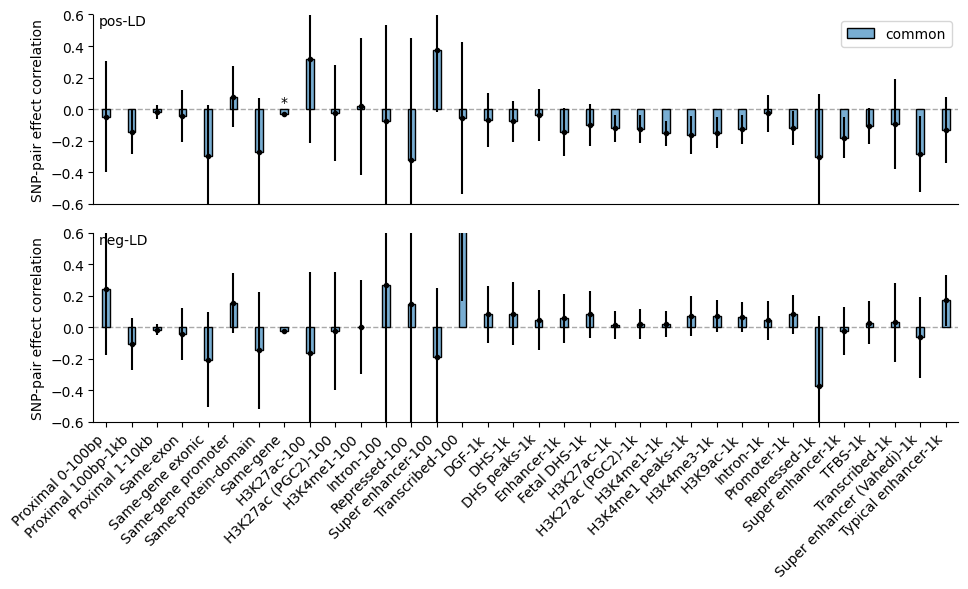

In [11]:
# Figure
plt.figure(figsize=[3+0.2*len(plot_list),6])
# Upper: pos-LD
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1.5]) 
ax = plt.subplot(gs[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.errorbar(
    np.arange(df_plot.shape[0]), df_plot['cor.p0_p100.%s'%mbin], 
    yerr=df_plot['cor.p0_p100.%s.se'%mbin]*1.96, fmt= '.', color='k',
)    
plt.bar(
    np.arange(df_plot.shape[0]), df_plot['cor.p0_p100.%s'%mbin], 
    width=0.3, alpha=1, linewidth=1, edgecolor='k', label=DIC_NAME[mbin], color=DIC_COLOR[mbin]
)
for i_row,row in enumerate(df_plot.index):
    plt.text(
        i_row, 
        max(0, (
            df_plot.loc[row, 'cor.p0_p100.%s'%mbin] + df_plot.loc[row,'cor.p0_p100.%s.se'%mbin] * 1.96
        )),
        df_plot.loc[row, 'cor.p0_p100.%s.sig_str'%mbin], ha='center', va='bottom',
    ) 

plt.xticks([])
plt.plot([-0.5, df_plot.shape[0]-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.ylim([-0.6, 0.6])
plt.text(-0.3, 0.6, 'pos-LD', ha='left', va='top')
plt.ylabel(DIC_NAME['cor'])
# plt.title('Proximity-based and gene-based annotations')
plt.legend(loc='upper right')

# Middle: neg-LD
ax = plt.subplot(gs[1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.errorbar(
    np.arange(df_plot.shape[0]), df_plot['cor.n100_p0.%s'%mbin], 
    yerr=df_plot['cor.n100_p0.%s.se'%mbin]*1.96, fmt= '.', color='k',
)   
plt.bar(
    np.arange(df_plot.shape[0]), df_plot['cor.n100_p0.%s'%mbin], 
    width=0.3, alpha=1, linewidth=1, edgecolor='k', label=DIC_NAME[mbin], color=DIC_COLOR[mbin]
)
for i_row,row in enumerate(df_plot.index):
    plt.text(
        i_row, 
        max(0, (
            df_plot.loc[row, 'cor.n100_p0.%s'%mbin] + df_plot.loc[row,'cor.n100_p0.%s.se'%mbin] * 1.96
        )),
        df_plot.loc[row, 'cor.n100_p0.%s.sig_str'%mbin], ha='center', va='bottom',
    ) 

plt.xticks([])
plt.plot([-0.5, df_plot.shape[0]-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.ylim([-0.6, 0.6])
plt.text(-0.3, 0.6, 'neg-LD', ha='left', va='top')
plt.ylabel(DIC_NAME['cor'])
plt.xticks(np.arange(df_plot.shape[0]),[DIC_NAME[x] if x in DIC_NAME else x for x in df_plot.index],
           rotation=45, ha='right')

plt.tight_layout()
plt.savefig(FIG_PATH + '/fig2.eas2k.pdf')
plt.show()

In [12]:
# JN p-value for difference 
md = 'prox_gene_fct_all_ld_EAS2K'
term = 'cor' 
prox_list = ['proxy_0_100', 'proxy_100_1000', 'proxy_1000_10000']
gene_list = ['exon', 'exonic_gene', 'cS2G_promoter', 'protein_domain', 'gene']
plot_list = plot_list_main + plot_list_100 + plot_list_1k
compare_dic = {
    'all;n100_p0;p0_p100' : [('pAN:%s_ld_@_maf_common_block'%x, ('n100_p0', 'p0_p100')) for x in plot_list],
}

n_hypothesis = len(plot_list)

df_jndif_list = []
for compare_term in compare_dic:
    print(compare_term)
    compare_list = compare_dic[compare_term]
    df_res = pd.DataFrame(
        columns=['pAN', 'strat1', 'start2', 'pAN1', 'mean1', 'se1', 'pAN2', 'mean2', 'se2', 
                 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str'], 
        dtype=float,
    )
    for i_pair, (pAN, (strat1, strat2)) in enumerate(compare_list):
        pAN1,pAN2 = pAN.replace('@', strat1),pAN.replace('@', strat2)
        esti_list,se_list = [],[]
        df_res.loc[i_pair, ['pAN', 'strat1', 'start2', 'pAN1', 'pAN2']] = [pAN, strat1, strat2, pAN1, pAN2]
        df_res.loc[i_pair, ['mean1', 'se1']] = dic_res_meta[md]['omega'].loc[pAN1, [term, '%s_se'%term]].values
        df_res.loc[i_pair, ['mean2', 'se2']] = dic_res_meta[md]['omega'].loc[pAN2, [term, '%s_se'%term]].values
        for trait in TRAIT_LIST_INDPT10:
            temp_dic_jn = dic_res[md][trait]['summary']['dic_jn']
            esti1 = {x:y for x,y in zip(temp_dic_jn['res_pAN_list'], temp_dic_jn[term])}[pAN1]
            esti2 = {x:y for x,y in zip(temp_dic_jn['res_pAN_list'], temp_dic_jn[term])}[pAN2]
            temp_df = pd.DataFrame(data=temp_dic_jn['%s.jn'%term], columns=temp_dic_jn['res_pAN_list'])
            v_mean_jn, mat_cov_jn = ldspec.regress.bjn(
                [esti1 - esti2], temp_df[pAN1] - temp_df[pAN2], temp_dic_jn['v_h']
            )
            esti_list.append(v_mean_jn[0])
            se_list.append(np.sqrt(mat_cov_jn[0,0]))        
        mean_,se_ = ldspec.util.meta_analysis(np.array(esti_list), np.array(se_list))
        p_ = ldspec.util.zsc2pval(mean_ / se_)
        df_res.loc[i_pair, ['dif', 'dif_se', 'dif_p']] = [mean_, se_, p_]
    df_res['dif_fwer'] = df_res['dif_p'] * n_hypothesis
    print('# hypothesis: %d' % n_hypothesis)
    df_res['dif_sig_str'] = ['*' if x<0.05 else '' for x in df_res['dif_fwer']]
    
    df_res['pAN'] = [
        x.replace('pAN:','').replace('_proxy','').replace('_ld','').replace('_block','') 
        for x in df_res['pAN']
    ]
    display(df_res[[
        'pAN', 'strat1', 'start2', 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str', 
        'mean1', 'se1', 'mean2', 'se2', 
    ]])
    
    df_jndif_list.append(
        df_res[['pAN', 'strat1', 'start2', 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str']]
    )
df_jndif = pd.concat(df_jndif_list, axis=0)
df_jndif.to_csv(TAB_PATH+'/fig2.eas2k.jndif.tsv', sep='\t', index=False)

print('sig-pos: ', ((df_jndif['dif_sig_str']=='*') & (df_jndif['dif']>0)).sum())
print('non-sig-pos: ', ((df_jndif['dif_sig_str']=='') & (df_jndif['dif']>0)).sum())
print('sig-neg: ', ((df_jndif['dif_sig_str']=='*') & (df_jndif['dif']<0)).sum())
print('non-sig-neg: ', ((df_jndif['dif_sig_str']=='') & (df_jndif['dif']<0)).sum())

all;n100_p0;p0_p100
# hypothesis: 34


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,proxy_0_100_@_maf_common,n100_p0,p0_p100,0.190750,0.206322,3.552112e-01,1.207718e+01,,0.246090,0.213721,-0.047349,0.178270
1,proxy_100_1000_@_maf_common,n100_p0,p0_p100,0.040309,0.054192,4.569876e-01,1.553758e+01,,-0.106983,0.083382,-0.143256,0.072433
2,proxy_1000_10000_@_maf_common,n100_p0,p0_p100,0.006650,0.011860,5.750345e-01,1.955117e+01,,-0.013903,0.018841,-0.016851,0.023092
3,exon_@_maf_common,n100_p0,p0_p100,0.032431,0.027476,2.378680e-01,8.087511e+00,,-0.040351,0.084651,-0.043431,0.084869
4,exonic_gene_@_maf_common,n100_p0,p0_p100,0.077410,0.026531,3.525759e-03,1.198758e-01,,-0.204376,0.152364,-0.300245,0.167047
5,cS2G_promoter_@_maf_common,n100_p0,p0_p100,0.066988,0.032306,3.812194e-02,1.296146e+00,,0.151756,0.097027,0.079480,0.097821
6,protein_domain_@_maf_common,n100_p0,p0_p100,0.156626,0.054307,3.925452e-03,1.334654e-01,,-0.145731,0.189553,-0.269788,0.174459
7,gene_@_maf_common,n100_p0,p0_p100,0.003164,0.000846,1.833225e-04,6.232966e-03,*,-0.025307,0.005290,-0.029343,0.004560
8,H3K27ac_Hnisz_0_100_@_maf_common,n100_p0,p0_p100,-0.426393,0.242616,7.883669e-02,2.680447e+00,,-0.162349,0.262321,0.320753,0.272338
9,H3K27ac_PGC2_0_100_@_maf_common,n100_p0,p0_p100,-0.040350,0.253170,8.733698e-01,2.969457e+01,,-0.023963,0.191977,-0.025149,0.153994


sig-pos:  15
non-sig-pos:  15
sig-neg:  0
non-sig-neg:  4


# hypothesis: 68


,mean1,se1,mean2,se2,dif,dif_se,dif_z,dif_p,dif_fwer


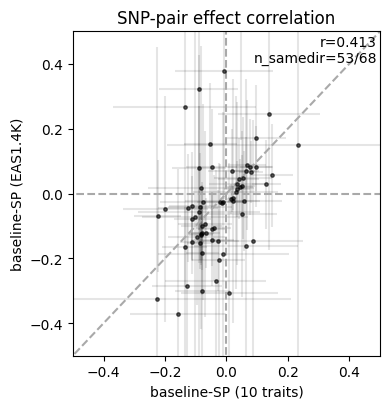

In [13]:
# Correlation with baseline-SP
for md1,md2 in [
    # ['md_prox_gene_fct_all_ld', 'prox_gene_fct_all_ld_EAS2K'],
    ['md_prox_gene_fct_all_ld.indpt10', 'prox_gene_fct_all_ld_EAS2K'],
]:
    row_list = [x for x in dic_res_meta[md1]['omega'].index if x in dic_res_meta[md2]['omega'].index]
#     row_list = [x for x in row_list if 'p0_p100' in x]
#     row_list = [x for x in row_list if 'n100_p0' in x]
    df_plot = pd.DataFrame(index=row_list, columns=['mean1', 'se1', 'mean2', 'se2'], dtype=float)
    for row in row_list:
        df_plot.loc[row, ['mean1', 'se1']] = dic_res_meta[md1]['omega'].loc[row, ['cor', 'cor_se']].values
        df_plot.loc[row, ['mean2', 'se2']] = dic_res_meta[md2]['omega'].loc[row, ['cor', 'cor_se']].values
    df_plot['dif'] = df_plot['mean1'] - df_plot['mean2']
    df_plot['dif_se'] = np.sqrt(df_plot['se1']**2 + df_plot['se2']**2)
    df_plot['dif_z'] = df_plot['dif'] / df_plot['dif_se']
    df_plot['dif_p'] = ldspec.util.zsc2pval(df_plot['dif_z']) 
    df_plot['dif_fwer'] = df_plot['dif_p'] * 68
    print('# hypothesis: %d' % 68)

    ind_select = df_plot['dif_fwer']<0.05
    display(df_plot.loc[ind_select])   
    
    plt.figure(figsize=[4,4.2])   
    plt.scatter(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'], s=6, alpha=0.6, color='k', zorder=5)
    plt.errorbar(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'], 
                 xerr=df_plot.loc[~ind_select, 'se1']*1.96, yerr=df_plot.loc[~ind_select, 'se2']*1.96, 
                 fmt='none', color='k', alpha=0.1, zorder=0)
    plt.errorbar(df_plot.loc[ind_select, 'mean1'], df_plot.loc[ind_select, 'mean2'], 
                 xerr=df_plot.loc[ind_select, 'se1']*1.96, yerr=df_plot.loc[ind_select, 'se2']*1.96, 
                 fmt= '.', color='C0', zorder=10)
    
    texts = []
    for row in df_plot.index[ind_select]:
        texts.append(plt.text(
            df_plot.loc[row, 'mean1'], df_plot.loc[row, 'mean2'], DIC_NAME[row], fontsize=10, zorder=10,
        ))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    
    # reference lines
    min_ = min(plt.xlim()[0], plt.ylim()[0])
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([min_, max_], [0, 0], '--', linewidth=1.5, color='darkgrey', zorder=0)
    plt.plot([0, 0], [min_, max_], '--', linewidth=1.5, color='darkgrey', zorder=0)
    plt.plot([min_, max_], [min_, max_], '--', linewidth=1.5, color='darkgrey', zorder=0)
    plt.xlim([min_, max_])
    plt.ylim([min_, max_])
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    
    plt.title('%s' % DIC_NAME['cor'])
    plt.xlabel(DIC_NAME[md1])
    plt.ylabel(DIC_NAME[md2])
    
    corr = np.corrcoef(df_plot['mean1'], df_plot['mean2'])[0,1]
    # corr_adj = ldspec.util.corrected_correlation(df_plot['mean1'], df_plot['mean2'], df_plot['se1'], df_plot['se2'])
    n_samedir = ((df_plot['mean1']*df_plot['mean2'])>0).sum()
    plt.text(0.99, 0.99, 'r=%0.3f\nn_samedir=%d/%d' % (corr, n_samedir, df_plot.shape[0]),
             ha='right', va='top', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/compare.cor.%s.%s.pdf' % (md1,md2))
    plt.show()

# hypothesis: 68


,mean1,se1,mean2,se2,dif,dif_se,dif_z,dif_p,dif_fwer


remove nan rows 5


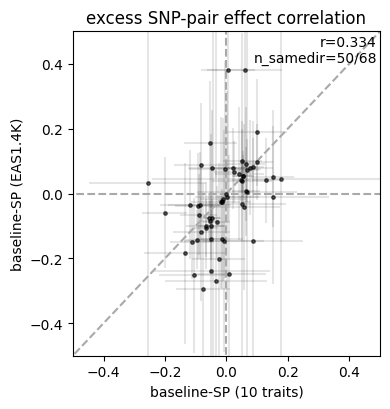

remove nan rows 5
cor=0.334


In [14]:
# Correlation with baseline-SP
df_list = []
for md1,md2 in [
    # ['md_prox_gene_fct_all_ld', 'prox_gene_fct_all_ld_EAS2K'],
    ['md_prox_gene_fct_all_ld.indpt10', 'prox_gene_fct_all_ld_EAS2K'],
]:
    row_list = [x for x in dic_res_meta[md1]['omega'].index if x in dic_res_meta[md2]['omega'].index]
#     row_list = [x for x in row_list if 'p0_p100' in x]
#     row_list = [x for x in row_list if 'n100_p0' in x]
    df_plot = pd.DataFrame(index=row_list, columns=['mean1', 'se1', 'mean2', 'se2'], dtype=float)
    for row in row_list:
        df_plot.loc[row, ['mean1', 'se1']] = dic_res_meta[md1]['omega'].loc[row, ['ecor', 'ecor_se']].values
        df_plot.loc[row, ['mean2', 'se2']] = dic_res_meta[md2]['omega'].loc[row, ['ecor', 'ecor_se']].values
    df_plot['dif'] = df_plot['mean1'] - df_plot['mean2']
    df_plot['dif_se'] = np.sqrt(df_plot['se1']**2 + df_plot['se2']**2)
    df_plot['dif_z'] = df_plot['dif'] / df_plot['dif_se']
    df_plot['dif_p'] = ldspec.util.zsc2pval(df_plot['dif_z']) 
    df_plot['dif_fwer'] = df_plot['dif_p'] * 68
    print('# hypothesis: %d' % 68)
    df_list.append(df_plot)

    ind_select = df_plot['dif_fwer']<0.05
    display(df_plot.loc[ind_select])   
    
    plt.figure(figsize=[4,4.2])   
    plt.scatter(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'], s=6, alpha=0.6, color='k', zorder=5)
    plt.errorbar(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'], 
                 xerr=df_plot.loc[~ind_select, 'se1']*1.96, yerr=df_plot.loc[~ind_select, 'se2']*1.96, 
                 fmt='none', color='k', alpha=0.1, zorder=0)
    # plt.scatter(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'],  
    #             s=4, color='k', alpha=0.6, zorder=5)
    # plt.errorbar(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'], 
    #              xerr=df_plot.loc[~ind_select, 'se1']*1.96, yerr=df_plot.loc[~ind_select, 'se2']*1.96, 
    #              fmt= '.', color='k', alpha=0.2, zorder=0)
    plt.errorbar(df_plot.loc[ind_select, 'mean1'], df_plot.loc[ind_select, 'mean2'], 
                 xerr=df_plot.loc[ind_select, 'se1']*1.96, yerr=df_plot.loc[ind_select, 'se2']*1.96, 
                 fmt= '.', color='C0', zorder=10)
    
    texts = []
    for row in df_plot.index[ind_select]:
        texts.append(plt.text(
            df_plot.loc[row, 'mean1'], df_plot.loc[row, 'mean2'], DIC_NAME[row], fontsize=10, zorder=10,
        ))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    
    # reference lines
    min_ = min(plt.xlim()[0], plt.ylim()[0])
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([min_, max_], [0, 0], '--', linewidth=1.5, color='darkgrey', zorder=0)
    plt.plot([0, 0], [min_, max_], '--', linewidth=1.5, color='darkgrey', zorder=0)
    plt.plot([min_, max_], [min_, max_], '--', linewidth=1.5, color='darkgrey', zorder=0)
    plt.xlim([min_, max_])
    plt.ylim([min_, max_])
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    
    plt.title('%s' % DIC_NAME['ecor'])
    plt.xlabel(DIC_NAME[md1])
    plt.ylabel(DIC_NAME[md2])
    
    # 
    ind_nan = df_plot.isna().sum(axis=1)>0
    print('remove nan rows', ind_nan.sum())
    corr = np.corrcoef(df_plot.loc[~ind_nan, 'mean1'], df_plot.loc[~ind_nan, 'mean2'])[0,1]
    n_samedir = ((df_plot['mean1']*df_plot['mean2'])>0).sum()
    plt.text(0.99, 0.99, 'r=%0.3f\nn_samedir=%d/%d' % (corr, n_samedir, df_plot.shape[0]),
             ha='right', va='top', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/compare.ecor.%s.%s.pdf' % (md1,md2))
    plt.show()

    temp_df = pd.concat(df_list, axis=0)
    ind_nan = temp_df.isna().sum(axis=1)>0
    print('remove nan rows', ind_nan.sum())
    temp_df = temp_df.loc[~ind_nan]
    print('cor=%0.3f' % (np.corrcoef(temp_df['mean1'], temp_df['mean2'])[0,1]))


In [15]:
np.random.seed(42)

# Step 1: Simulate true values with known correlation
n = 500
r_true = 0.7  # true correlation between x and y

# Generate bivariate normal (x_true, y_true)
mean = [0, 0]
cov = [[1, r_true], [r_true, 1]]
x_true, y_true = np.random.multivariate_normal(mean, cov, size=n).T

# Step 2: Add measurement error based on standard errors
se_x = np.random.uniform(0.2, 0.5, size=n)  # standard errors for x
se_y = np.random.uniform(0.2, 0.5, size=n)  # standard errors for y

x_obs = x_true + np.random.normal(0, se_x)
y_obs = y_true + np.random.normal(0, se_y)

r_obs, r_corrected = ldspec.util.corrected_correlation(x_obs, y_obs, se_x, se_y)

# Step 4: Report results
print(f"True correlation:       {r_true:.3f}")
print(f"Observed correlation:   {r_obs:.3f}")
print(f"Corrected correlation:  {r_corrected:.3f}")

True correlation:       0.700
Observed correlation:   0.613
Corrected correlation:  0.696


### Old code